# Q-CTRL tutorial: Robust control

This notebook is designed to be presented. To learn more after the presentation see: [How to optimize controls robust to strong noise sources](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-optimize-controls-robust-to-strong-noise-sources) and [How to tune the learning rate of a stochastic optimization](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-tune-the-learning-rate-of-a-stochastic-optimization#how-to-tune-the-learning-rate-of-a-stochastic-optimization).

## Example: Robust optimization of state transfer of a single qubit

In this example we optimize a control pulse applied to an ensemble of two level atoms that transfers the state from the ground state to the first excited state. 

Consider the Hamiltonian of a ensemble of two level atoms which have variable detuning from the driving laser field

$$
\tilde{H}(t,\mathbf{p}) = \frac{\tilde{\zeta}}{2} \sigma_z + \Big(\gamma(t,\mathbf{p}) \sigma^\dagger + H.c.\Big)  ,
$$

where
$\sigma$ is the annihilation operator of the two level system,
$\sigma_z$ is the sigma_z pauli matrix,
$\tilde{\zeta}$ is a detuning that varies from atom to atom and hence can be treated as a random variable sampled from a normal distribution $\mathcal{N}(0, \nu)$,
$\gamma(t,\mathbf{p})$ is a complex time-dependent drive applied to the that is parametrized by a vector of control variables $\bf{p}$ and the tilde indicates the operator or variable is stochastic.

Consider the robust control problem of trying to find a drive $\gamma(t)$ which aims to transfer the state of the ensemble of atoms from $|\psi \rangle_{\mathrm{initial}}=|0 \rangle$ to a final target state $|\psi_{\mathrm{target}} \rangle = |1 \rangle$.

This internally achieved by performing an optimization problem that minimizes the average cost

$$
C(\mathbf{p}) = \mathbb{E}[  1 - || \langle \psi_{\mathrm{target}} | \tilde{\psi}_{\mathrm{final}}(\mathbf{p}) \rangle ||^2]
$$

where $\mathbb{E}$ is the classical expectation over the stochastic variables, $| \tilde{\psi}_{\mathrm{final}}(\mathbf{p}) \rangle = |\tilde{\psi}(T,\mathbf{p}) \rangle $ is the solution of the differential equation

$$
\frac{d|\tilde{\psi}(t)\rangle}{dt} = -i \tilde{H}(t,\mathbf{p}) |\psi(t)\rangle
$$

with the initial condition of $|\tilde{\psi}(0)\rangle = |\tilde{\psi}_{\mathrm{initial}}\rangle$.

After the optimization is completed, the history of the costs over each iteration is returned along with the best cost average cost and best controls.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Q-CTRL imports
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_cost_history, plot_populations, plot_controls

# Starting a session with the API
qctrl = Qctrl()

# Plotting style
plt.style.use(get_qctrl_style())

In [2]:
# Define optimization parameters.
omega_max = 2 * np.pi * 25e3  # Hz
duration = 200e-6  # s
segment_count = 80
sample_count = 100
noise_count = 400

# Create optimization graph.
graph = qctrl.create_graph()

# Define optimizable pulses, start with square pulse.
signal = graph.utils.complex_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    maximum=omega_max,
    name="drive"
)

# Create drive term of the Hamiltonian.
drive_term = (
    graph.real(signal) * graph.pauli_matrix("X") / 2.0 + graph.imag(signal) * graph.pauli_matrix("Y") / 2.0
)

# Create dephasing noise realizations.
dephasing_noise = graph.random_normal(
    mean=0, standard_deviation=2e4, shape=(noise_count, 1)
)
dephasing_noise_pwc = graph.constant_pwc(
    constant=dephasing_noise, duration=duration, batch_dimension_count=1
)
dephasing_term = dephasing_noise_pwc * graph.pauli_matrix("Z")

# Define batch of infidelities.
hamiltonian = drive_term + dephasing_term
infidelities = graph.infidelity_pwc(
    hamiltonian=hamiltonian, target=graph.target(graph.pauli_matrix("X"))
)

# Calculate cost as the average of the infidelities.
cost = graph.sum(infidelities) / noise_count
cost.name = "cost"

sample_times = np.linspace(0, duration, sample_count)
    
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)

initial_state = graph.fock_state(2, 0)[None,None,:,None]

evolved_states = unitaries @ initial_state
evolved_states.name = "evolved_states"


In [3]:
# Run optimization for each value of the learning rate.

result = qctrl.functions.calculate_stochastic_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=["cost","evolved_states","drive"],
        optimizer={"adam": {"learning_rate": 0.1}},
        cost_history_scope="HISTORICAL_BEST",
        iteration_count=300,)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_stochastic_optimization (action_id="1253387") has started.
Your task calculate_stochastic_optimization (action_id="1253387") has completed.


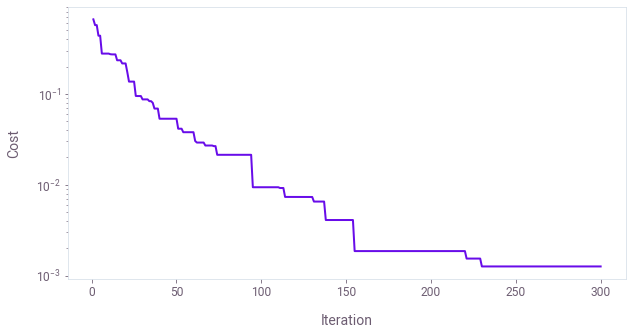

In [4]:
# Plot best cost history for each value of the learning rate.
fig = plt.figure()
plot_cost_history(
    fig,
    cost_histories=[result.cost_history.historical_best]
)

In [5]:
print(f"Optimized infidelity: {result.best_cost:.3e}")

Optimized infidelity: 1.266e-03


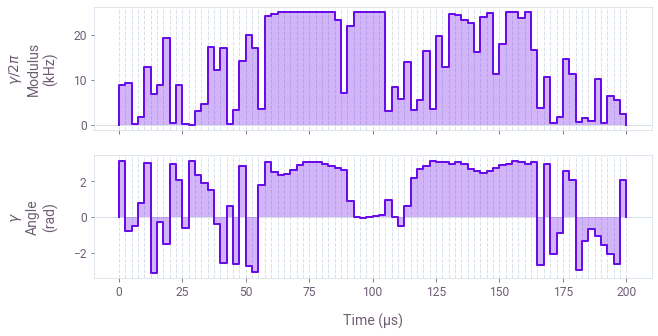

In [9]:
optimized_drive = result.best_output["drive"]
plot_controls(
    plt.figure(),
    {
        r"$\gamma$": optimized_drive,
    },
)

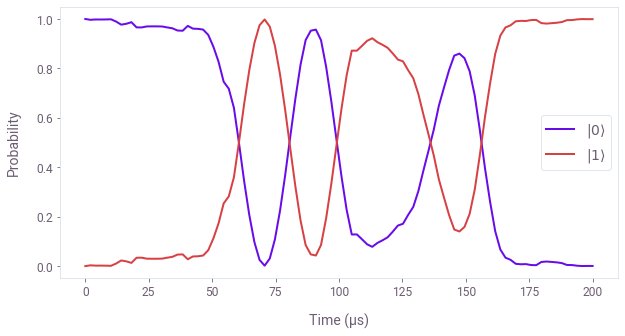

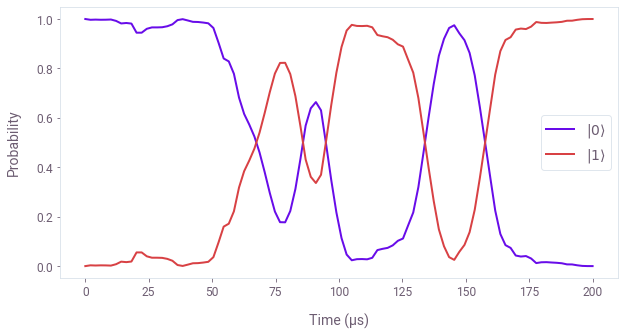

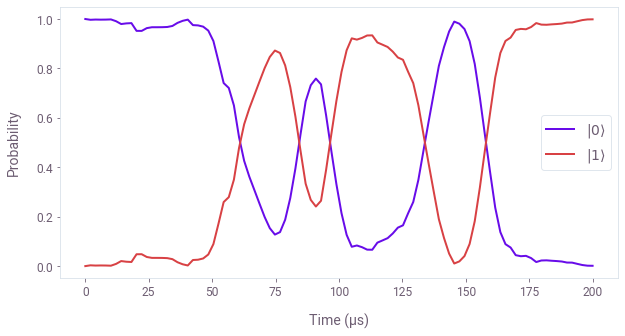

In [10]:
state_vectors = result.best_output['evolved_states']['value']
populations = np.abs(state_vectors)**2

for path in range(3):

    plot_populations(
        plt.figure(),
        sample_times,
        {rf"$|{state}\rangle$": populations[path,:, state] for state in range(2)},
    )


## Problem: Tuning a robust optimization

Here we consider the robust control problem of state transfer for an ensemble of atoms being driven by a laser field with amplitude noise. The Hamiltonian of this system is similar to before, but has an additional stochastic factor due to the laser fluctuations

$$
\tilde{H}(t,\mathbf{p}) = \frac{\tilde{\zeta}}{2} \sigma_z + (1 + \tilde{\beta})\Big(\gamma(t,\mathbf{p}) \sigma^\dagger + H.c.\Big)  ,
$$

where 
\tilde{\beta} is a stochastic variable due to the laser noise fluctuations it is sampled from a normal distribution $\mathcal{N}(0,\mu)$.

When we add these additional noises the fidelity of the noise reduces.

Can you improve the fidelity of the pulses by changing the parameters of the stochastic optimization? I.e. keep the parameters of the control pulses fixed. 

In [11]:
# Define optimization parameters.
omega_max = 2 * np.pi * 25e3  # Hz
duration = 200e-6  # s
segment_count = 80
sample_count = 100
noise_count = 400

# Create optimization graph.
graph = qctrl.create_graph()

# Define optimizable pulses, start with square pulse.
signal = graph.utils.complex_optimizable_pwc_signal(
    segment_count=segment_count,
    duration=duration,
    maximum=omega_max,
    name="drive"
)

# Create drive term of the Hamiltonian.
drive_term = (
    graph.real(signal) * graph.pauli_matrix("X") / 2.0 + graph.imag(signal) * graph.pauli_matrix("Y") / 2.0
)

# Create dephasing noise realizations.
dephasing_noise = graph.random_normal(
    mean=0, standard_deviation=2e4, shape=(noise_count, 1)
)
dephasing_noise_pwc = graph.constant_pwc(
    constant=dephasing_noise, duration=duration, batch_dimension_count=1
)
dephasing_term = dephasing_noise_pwc * graph.pauli_matrix("Z")

# Create amplitude noise realizations.
amplitude_noise = graph.random_normal(
    mean=0, standard_deviation=0.2, shape=(noise_count, 1)
)
amplitude_noise_pwc = graph.constant_pwc(
    constant=amplitude_noise, duration=duration, batch_dimension_count=1
)

# Define batch of infidelities.
hamiltonian = (1 + amplitude_noise_pwc) * drive_term + dephasing_term
infidelities = graph.infidelity_pwc(
    hamiltonian=hamiltonian, target=graph.target(graph.pauli_matrix("X"))
)

# Calculate cost as the average of the infidelities.
cost = graph.sum(infidelities) / noise_count
cost.name = "cost"

sample_times = np.linspace(0, duration, sample_count)
    
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)

initial_state = graph.fock_state(2, 0)[None,None,:,None]

evolved_states = unitaries @ initial_state
evolved_states.name = "evolved_states"


In [12]:
# Run optimization for each value of the learning rate.

result = qctrl.functions.calculate_stochastic_optimization(
        graph=graph,
        cost_node_name="cost",
        output_node_names=["cost","evolved_states","drive"],
        optimizer={"adam": {"learning_rate": 0.1}},
        cost_history_scope="HISTORICAL_BEST",
        iteration_count=300,)

  0%|          | 0/100 [00:00<?, ?it/s]

Your task calculate_stochastic_optimization (action_id="1253388") has started.
Your task calculate_stochastic_optimization (action_id="1253388") has completed.


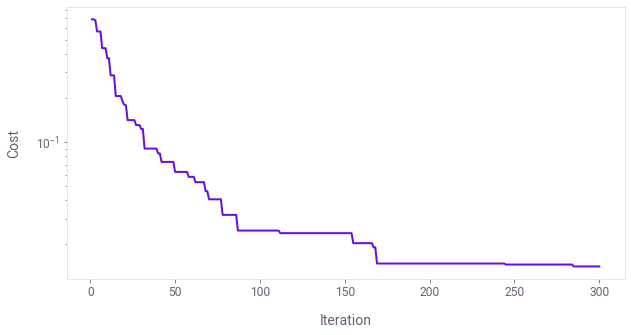

In [13]:
# Plot best cost history for each value of the learning rate.
fig = plt.figure()
plot_cost_history(
    fig,
    cost_histories=[result.cost_history.historical_best]
)

In [14]:
print(f"Optimized infidelity: {result.best_cost:.3e}")

Optimized infidelity: 1.415e-02


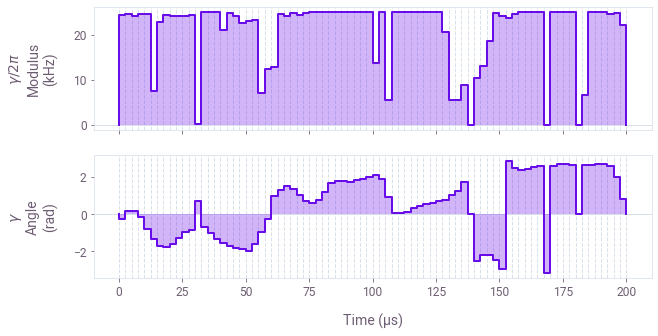

In [16]:
optimized_drive = result.best_output["drive"]
plot_controls(
    plt.figure(),
    {
        r"$\gamma$": optimized_drive,
    },
)

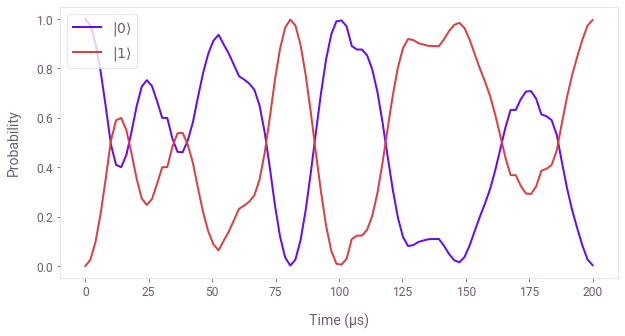

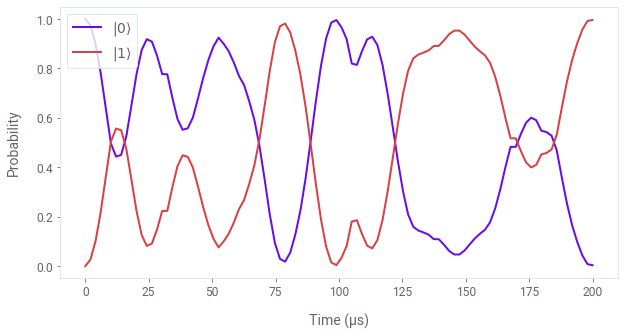

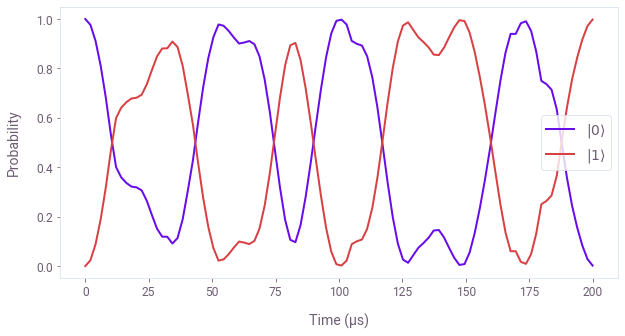

In [17]:
state_vectors = result.best_output['evolved_states']['value']
populations = np.abs(state_vectors)**2

for path in range(3):

    plot_populations(
        plt.figure(),
        sample_times,
        {rf"$|{state}\rangle$": populations[path,:, state] for state in range(2)},
    )


## Homework: Robust optimization of state transfer for a three-level atom

Can you create a robust optimization that completed a state transfer from the ground state to the second excited state of an ensemble of three level atom?